# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a very brief presentation covering the following points:
    * Introduction to the problem (what are we trying to achieve and why) - max 1 slide
    * Libraries used - max 1 slide
    * Data Processing Pipeline - max 2 slides
    * Feature Engineering (if relevant) - max 1 slide
    * Modeling - max 1 slide
    * Results & Visualization - max 2 slides
* The goal of the presentation is to make it **understandable by a business person**, apart from how modeling techniques which do not have to be explained how they work.

# Libraries Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import platform
import glob
import ntpath
import os
from scipy.io import wavfile

In [4]:
import torch
#from torch import Tensor
from torch import nn
import torch.nn.functional as F

In [5]:
import pandas_profiling
%matplotlib inline

/home/shernand/dl_epfl/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shernand/pythonroots/python_3.6.5_built/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shernand/pythonroots/python_3.6.5_built/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shernand/dl_epfl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shernand/dl_epfl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shernand/dl_epfl/lib/python3.6/site-pack

In [6]:
import json

In [7]:
import speechpy

In [8]:
from sklearn.model_selection import train_test_split

# Data Preparation & Cleaning

In [9]:
data_main_folder = 'data'
wav_folder = 'wav'

In [10]:
platform_system = platform.system()
file_separator=''
if(platform_system=='Windows'):
    file_separator = '\\'
else:#(platform_system=='Linux'):
    file_separator = '/'

In [11]:
wav_path = data_main_folder + file_separator + wav_folder

In [12]:
wav_files = glob.glob(wav_path+file_separator+'*.wav')
wav_files.sort()

In [13]:
wav_files[:1]

['data/wav/03a01Fa.wav']

## About the data

<h2>Additional Information</h2>


Every utterance is named according to the same scheme:
<ul><li>Positions 1-2: number of speaker
    <li>Positions 3-5: code for text
    <li>Position 6: emotion (sorry, letter stands for german emotion word)
    <li>Position 7: if there are more than two versions these are numbered a, b, c ....
</ul>

Example: 03a01Fa.wav is the audio file from Speaker 03 speaking text a01 with the emotion "Freude" (Happiness).

<h3>Information about the speakers</h3>

<ul><li>03 - male, 31 years old
    <li>08 - female, 34 years
    <li>09 - female, 21 years
    <li>10 - male, 32 years
    <li>11 - male, 26 years
    <li>12 - male, 30 years
    <li>13 - female, 32 years
    <li>14 - female, 35 years
    <li>15 - male, 25 years
    <li>16 - female, 31 years
</ul>

<table class="aussen" border="0" align="left" width="100%">
<tr><td>

<h3>Code of texts</h3>

<table align="left" width="800" bgcolor="#313131" border="1" frame="solid" rules="rows" cellpadding="3" cellspacing="1">
<tr><th>code</th><th>text (german)</th><th>try of an english translation</th></tr>
<tr><td class="mittig">a01</td><td>Der Lappen liegt auf dem Eisschrank.</td><td>The tablecloth is lying on the frigde.</td></tr>
<tr><td class="mittig">a02</td><td>Das will sie am Mittwoch abgeben.</td><td>She will hand it in on Wednesday.</td></tr>
<tr><td class="mittig">a04</td><td>Heute abend könnte ich es ihm sagen.</td><td>Tonight I could tell him.</td></tr>
<tr><td class="mittig">a05</td><td>Das schwarze Stück Papier befindet sich da oben neben dem Holzstück.</td><td>The black sheet of paper is located up there besides the piece of timber.</td></tr>
<tr><td class="mittig">a07</td><td>In sieben Stunden wird es soweit sein.</td><td>In seven hours it will be.</td></tr>
<tr><td class="mittig">b01</td><td>Was sind denn das für Tüten, die da unter dem Tisch stehen?</td><td>What about the bags standing there under the table?</td></tr>
<tr><td class="mittig">b02</td><td>Sie haben es gerade hochgetragen und jetzt gehen sie wieder runter.</td><td>They just carried it upstairs and now they are going down again.</td></tr>
<tr><td class="mittig">b03</td><td>An den Wochenenden bin ich jetzt immer nach Hause gefahren und habe Agnes besucht.</td><td>Currently at the weekends I always went home and saw Agnes.</td></tr>
<tr><td class="mittig">b09</td><td>Ich will das eben wegbringen und dann mit Karl was trinken gehen.</td><td>I will just discard this and then go for a drink with Karl.</td></tr>
<tr><td class="mittig">b10</td><td>Die wird auf dem Platz sein, wo wir sie immer hinlegen.</td><td>It will be in the place where we always store it.</td></tr>
</table>
<p>&nbsp;<br><p>

</td></tr>

<tr><td>

<h3><br>Code of emotions:</h3>

<table align="left" width="600" bgcolor="#313131" border="1" frame="solid" rules="rows" cellpadding="3" cellspacing="1">
<tr><th>letter</th><th>emotion (english)</th><th>letter</th><th>emotion (german)</th></tr>
<tr><td class="mittig">A</td><td>anger</td><td class="mittig">W</td><td>Ärger (Wut)</td></tr>
<tr><td class="mittig">B</td><td>boredom</td><td class="mittig">L</td><td>Langeweile</td></tr>
<tr><td class="mittig">D</td><td>disgust</td><td class="mittig">E</td><td>Ekel</td></tr>
<tr><td class="mittig">F</td><td>anxiety/fear</td><td class="mittig">A</td><td>Angst</td></tr>
<tr><td class="mittig">H</td><td>happiness</td><td class="mittig">F</td><td>Freude</td></tr>
<tr><td class="mittig">S</td><td>sadness</td><td class="mittig">T</td><td>Trauer</td></tr>
<tr><td colspan="4">N = neutral version</td></tr>

</td></tr>
</table>

</table>


# Constructing the dataset

In [14]:
emotion_german = ['W','L','E','A','F','T','N']
emotion_english = ['Anger','Boredom','Disgust','Fear','Happiness','Sadness','Neutral']
emotion_numbers = np.arange(0,7)

In [15]:
def loading_wav_file(file_wav, emotion_german,emotion_numbers):
    """Loads a wav file, and returns its respective y (label) and x (sound signal)."""
    path, filename = os.path.split(file_wav)
    filename, file_extension = os.path.splitext(filename)
    individual_number = int(filename[0:2])
    code_text = filename[2:5]
    emotion_label = filename[5]
    index_emotion = np.argwhere(np.char.strip(emotion_german)==emotion_label)[0][0]
    y = emotion_numbers[index_emotion]
    fs, x = wavfile.read(file_wav) 
    return y, x, fs, code_text, individual_number

In [16]:
y=[]
x=[]
fs_array=[]
code_text_array = []
ind_numb_array=[]
length_array = []
for file_wav in wav_files:
    y_file, x_file, fs, code_text, individual_number = loading_wav_file(file_wav, emotion_german,emotion_numbers)
    y.append(y_file)
    x.append(x_file)
    length_array.append(len(x_file))
    fs_array.append(fs)
    code_text_array.append(code_text)
    ind_numb_array.append(individual_number)

/home/shernand/dl_epfl/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [17]:
data_complete = pd.DataFrame(columns=['y','x','length','fs','ind_numb','text'])

In [18]:
x = np.array(x)
y = np.array(y)

In [19]:
data_complete['y'] = y
data_complete['x'] = x
data_complete['length'] = length_array
data_complete['fs'] = fs_array
data_complete['ind_numb'] = ind_numb_array
data_complete['text'] = code_text_array

# Profiling of the data-set

In [20]:
profile_file = pandas_profiling.ProfileReport(data_complete)
profile_file

Number of variables,6
Number of observations,535
Total Missing (%),0.0%
Total size in memory,25.2 KiB
Average record size in memory,48.1 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [21]:
data_complete.y.value_counts()

0    127
1     81
6     79
4     71
3     69
5     62
2     46
Name: y, dtype: int64

In [22]:
data_complete.length.describe()

count       535.000000
mean      44473.785047
std       16451.022909
min       19608.000000
25%       32425.500000
50%       41443.000000
75%       52934.500000
max      143652.000000
Name: length, dtype: float64

## Some Comments
1. **Sampling rate** is constant 16 kHz. This is nice so we do not have to handle variable sampling rate signals.
2. The **length** of each audio-sample **varies**. So we need to pad or cut signals. 
3. Label 0 (Anger) has the double of samples than the rest (**unbalanced data-set**). We may have to do data-augmentation to balance the data set.
4. Signals are quite **long** and are **audio** signals. It is a good idea to grab first some frequency-related features.

### First
Let us first remove the signals which have the longest (1%) length and the shortest length (1%) so we are sure we do not hold possible outliers.

In [23]:
data_complete_pr = data_complete[(data_complete.length > data_complete.length.quantile(.01))&(data_complete.length < data_complete.length.quantile(.99))]

In [24]:
profile_file_pr = pandas_profiling.ProfileReport(data_complete_pr)
profile_file_pr

Number of variables,7
Number of observations,523
Total Missing (%),0.0%
Total size in memory,28.7 KiB
Average record size in memory,56.2 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,2


In [25]:
data_complete_pr.y.value_counts()

0    126
1     81
6     77
4     71
3     66
5     56
2     46
Name: y, dtype: int64

In [26]:
data_complete.y.value_counts() - data_complete_pr.y.value_counts()

0    1
1    0
6    2
4    0
3    3
5    6
2    0
Name: y, dtype: int64

In [27]:
data_complete_pr.length.describe()

count      523.000000
mean     43939.990440
std      14623.477687
min      23632.000000
25%      32534.500000
50%      41443.000000
75%      52723.000000
max      95610.000000
Name: length, dtype: float64

So we removed around 12 samples (quite a lot)

# Feature Engineering & Modeling

Because the length of the signals vary quite a lot (min 23632.0 and max 95610.0) we have two possibilities. We can pad all the signals with 0s to match the longest signal's length (fun zero_pad_to_longest) or we can cut the signals to a minimal signal lenght (with some 0 padding) (fun cut_into_shorter_samples).

## Preprocessing, Feature Engineering and Standarizing
All the steps necessary to get our Tensors

In [28]:
longest_length = data_complete_pr.length.max()
shortest_length = data_complete_pr.length.min()
y_pr = data_complete_pr['y'].values
x_pr = data_complete_pr['x'].values
length_pr = data_complete_pr['length'].values

In [29]:
def cut_into_shorter_samples(x_sample,y_sample,lenght_sample, shortest_length, threshold):
    """Cuts the x signal into pieces of lenght shortest_length.
    For the last piece of signal it zero pad it. The threshold indicates at which proportion of shortest_length
    it considers it is worth to keep the last piece.
    Returns the list of x pieces of x, along with their respective y and length"""
    x_array = []
    y_array= []
    length_array = []
    diff_test = lenght_sample-shortest_length 
    len_to_process = lenght_sample
    if(diff_test>0):
        if(diff_test>shortest_length//threshold):
            numb_new_x = lenght_sample//shortest_length
            for i in range(numb_new_x+1):
                if(len_to_process>shortest_length):
                    new_x = x_sample[i*shortest_length:(i+1)*shortest_length]
                    x_array.append(new_x)
                    length_array.append(len(new_x))
                    y_array.append(y_sample)
                    len_to_process = lenght_sample-(i+1)*shortest_length 
                elif(len_to_process>shortest_length//threshold):
                    final_x = x_sample[i*shortest_length:]
                    len_pad = ((shortest_length-len(final_x))//2)
                    diff_len = len_to_process+2*len_pad - shortest_length
                    if(diff_len==0): x_pad = np.pad(final_x,pad_width =(len_pad,len_pad),mode ='constant',constant_values=0 )
                    elif(diff_len==-1): x_pad = np.pad(final_x,pad_width =(len_pad+1,len_pad),mode ='constant',constant_values=0 )
                    else: x_pad = np.pad(final_x,pad_width =(len_pad-1,len_pad),mode ='constant',constant_values=0 )
                    x_array.append(x_pad)
                    length_array.append(len(x_pad))
                    y_array.append(y_sample)
        else:
            new_x = x_sample[:shortest_length]
            x_array.append(new_x)
            length_array.append(len(new_x))
            y_array.append(y_sample)
    return  x_array, y_array, length_array

In [30]:
def zero_pad_to_longest(x_pr,lengtr_pr,longest_length):
    """Zero pads all the x signals to match the lenght given which is longer than all the lengths."""
    x_final = np.zeros((len(lengtr_pr),longest_length))
    length_array_final = [] #Just to check that indeed all are the same length
    for i  in range(len(x_pr)):
        len_pad = ((longest_length - length_pr[i])//2)
        diff_len = length_pr[i]+2*len_pad - longest_length
        if(diff_len==0): x_pad = np.pad(x_pr[i],pad_width =(len_pad,len_pad),mode ='constant',constant_values=0 )
        elif(diff_len==-1): x_pad = np.pad(x_pr[i],pad_width =(len_pad+1,len_pad),mode ='constant',constant_values=0 )
        else: x_pad = np.pad(x_pr[i],pad_width =(len_pad-1,len_pad),mode ='constant',constant_values=0 )
        x_final[i,:]=x_pad
        length_array_final.append(len(x_pad)) #Just to check that indeed all are the same length
    return x_final,length_array_final

Here we proceed with matching the signal lenghts to the minimum signal length.

In [31]:
shorter_x = []
#shorter_lengths = [] #To verify that indeed the lenghts will become a constant.
shorter_y = []
for i  in range(len(x_pr)):
    x_array, y_array, length_array = cut_into_shorter_samples(x_pr[i],y_pr[i],length_pr[i], shortest_length, 5)
    for x_g, y_g, l_g in zip(x_array,y_array,length_array):
        shorter_x.append(x_g)
        shorter_y.append(y_g)
        #shorter_lengths.append(l_g) #To verify that indeed the lenghts will become a constant.
shorter_x = np.array(shorter_x)
shorter_y = np.array(shorter_y)
#shorter_lengths = np.array(shorter_lengths) #To verify that indeed the lenghts will become a constant.

Now we proceed into getting frequency-based properties. We use the [speechpy library](https://github.com/astorfi/speechpy) to get the [Mel-frequency_cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), <<a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency>>. For it we base our approach to [Hemanth Kumar Veeranki's](https://github.com/harry-7/speech-emotion-recognition/blob/master/speechemotionrecognition/utilities.py).

In [284]:
def get_mfcc(x,fs,mfcc_len=35):
    mfcc = speechpy.feature.mfcc(x, fs, num_cepstral=mfcc_len)
    return mfcc

In [285]:
mfcc_array = []
fs = data_complete.fs.values[0]
for i  in range(len(shorter_x)):
    mfcc_array.append(get_mfcc(shorter_x[i],fs))
mfcc_array = np.array(mfcc_array)

In [286]:
print(np.shape(mfcc_array))

(1137, 145, 35)


We now proceed to form our train and test sets.

In [287]:
X_train , X_test, y_train, y_test = train_test_split(mfcc_array, shorter_y, test_size=0.2)

In [288]:
print("X_Train: ", np.shape(X_train))
print("X_test: ", np.shape(X_test))

X_Train:  (909, 145, 35)
X_test:  (228, 145, 35)


In [289]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [719]:
test_input = torch.from_numpy((X_test - X_train.mean(axis=0))/X_train.std(axis=0)).float().to(device)
train_input = torch.from_numpy((X_train - X_train.mean(axis=0))/X_train.std(axis=0)).float().to(device)
test_target = torch.from_numpy(y_test).long().squeeze().to(device)
train_target = torch.from_numpy(y_train).long().squeeze().to(device)
print("Train input: ", train_input.size())
print("Test input: ", test_input.size())

Train input:  torch.Size([909, 145, 35])
Test input:  torch.Size([228, 145, 35])


In [720]:
reshape_data=False
if reshape_data:
    train_input = train_input.float().view(train_input.size(0), 35, -1)
    test_input = test_input.float().view(test_input.size(0), 35, -1)
    print("Train input: ", train_input.size())
    print("Test input: ", test_input.size())

## Utils for our Cross Validation and Training

In [531]:
def split_data(dataset,target,k_fold):
    """"
    Split a dataset in several subsets of equal size.
    Inputs : dataset -> original dataset
             target -> original target
             k_fold -> number of subsets required
    Outputs : all_datasets -> list of all subsets of the dataset
              all_targets -> list of subsets of the targets, matching with
                             all_datasets
    """
    N = dataset.size()[0]
    step = N//k_fold
    indices = torch.randperm(N);
    all_datasets = []
    all_targets = []
    for k in range(0,k_fold-1):
        all_datasets.append(dataset[indices[k*step:(k+1)*step]])
        all_targets.append(target[indices[k*step:(k+1)*step]])
    all_datasets.append(dataset[indices[(k_fold-1)*step:N]])
    all_targets.append(target[indices[(k_fold-1)*step:N]])
    return all_datasets, all_targets

def build_train_and_validation(all_datasets,all_targets,k_validation,k_fold):
    """
    Create a train set and a validation set from a list of subsets.
    Inputs : all_datasets -> list of datasets
             all_targets -> list of targets, matching with all_datasets
             k_validation -> index in the list of the subset that should be
                             used as the validation set
             k_fold -> number of subsets
    Outputs : train_data, train_target -> Train set
              validation_data, validation_target -> Validation set
    """
    assert((k_validation >= 0) & (k_validation < k_fold)),'Index of the validation set is out of bounds'
    train = list(range(0,k_validation))+list(range(k_validation + 1, k_fold))
    train_data = torch.cat([all_datasets[i] for i in train])
    train_target = torch.cat([all_targets[i] for i in train])
    validation_data = all_datasets[k_validation]
    validation_target = all_targets[k_validation]
    return train_data, train_target, validation_data, validation_target

def train_model(model, criterion, optimizer, scheduler,train_input, train_target,n_epochs=250,batch_size=50,verbose=0,save_loss=False,tr_loss=[],val_loss=[],tr_err=[],val_err=[],val_input=torch.Tensor(),val_target=torch.Tensor()):
    """
    Trains the model, using criterion as the loss function, and the optimizer wrapped in scheduler
    Inputs: model -> the model to be trained (torch.nn.Module)
            criterion -> loss function to be used for optimization
            optimizer -> optimization algorithm
            scheduler -> scheduler, changing the learning rate throughout the epochs
            train_input -> input for training, size: (n_samples, n_channels, time_points)
            train_target -> trarget values, size: (n_samples)
            n_epochs -> number of passes through the whole dataset in training
            batch_size -> the batch size for training
            n_augmentation -> number of copies of the dataset with added noise that are to be appended to (train_input, train_target)
            verbose -> manages output: 1 - only informs about end of training, while 2 about the current epoch % 20
            save_loss -> a boolean indicating whether to evaluate the error& loss of the model on the whole training and validation sets
            + lists to store results, if save_loss == True
    """
    # Augment the data if necessary and make Variables
    #train_input, train_target = Variable(train_input), Variable(train_target)
    #if(save_loss):
    #    val_input,val_target = Variable(val_input),Variable(val_target)
    #train_input.requires_grad_()
    #if(save_loss):
    #    val_input.requires_grad_()
    for e in range(n_epochs):
        scheduler.step() # decrease the learning rate
        if(verbose>=2):
            if(e % 20 == 19):
                print("Training epoch {} of {}".format(e+1,n_epochs),end='\r')

        # permutation of the samples, for batch training
        indices = torch.randperm(train_input.size(0))
        train_input = train_input[indices]
        train_target = train_target[indices]

        # train on batches
        for b in range(0,train_input.size(0),batch_size):
            if(train_input.size(0) - b >= batch_size):
                output = model(train_input.narrow(0,b,batch_size))
                loss = criterion(output,train_target.narrow(0,b,batch_size))
                #print("Loss: ",loss)
                model.zero_grad()
                loss.sum().backward()
                optimizer.step()
        # save loss data, if save_loss is true
        if(save_loss):
            tr_loss.append(criterion(model(train_input),train_target).item())
            val_loss.append(criterion(model(val_input),val_target).item())
            tr_err.append(evaluate_error(model,train_input.data,train_target.detach()))
            val_err.append(evaluate_error(model,val_input.data,val_target.detach()))
    if(verbose == 1):
        print("Training ended successfully after {} epochs".format(n_epochs))
def evaluate_error(model, data_input, data_target):
    """
    Evaluates the classification error on data_input, with respect to data_target
    Inputs: model -> the model to evaluate performance (torch.nn.Module)
            data_input -> input data to evaluate over
            data_target -> the correct labels for the input data
    Outputs: the number of missclassified samples
    """
    #data_input, data_target = Variable(data_input,volatile=True),Variable(data_target,volatile=True)
    #data_input.requires_grad_()
    with torch.no_grad():  
        correct = 0
        total = 0
        output = model(data_input)
        #print(output.data)
        temp, predicted = torch.max(output.data, 1)
        total += data_target.size(0)
        #print(predicted)
        #print(data_target)
        #(predicted == data_target)
        correct += (predicted == data_target).sum().item()
        return (100 * (1-(correct / total))) # take the mean, to get a fraction of missclassified samples

def cross_validate(model,criterion,optimizer,scheduler,dataset,target,k_fold,n_epochs=250,batch_size = 50,verbose=0):
    """
    Given a model and a dataset, performs k-fold cross validation and return
    the list of the errors on each fold.
    Inputs : model, optimizer, scheduler, n_epochs, batch_size -> look into train_model
             dataset, target -> dataset
             k_fold -> number of folds to use
    Outputs : train_errors -> list of the train error on each fold
              validation_errors -> list of the validation error on each fold
    """
    all_datasets, all_targets = split_data(dataset,target,k_fold) # prepare data for crossvalidation
    # containers for loss
    mean_tr_loss = [0 for i in range(n_epochs)]
    mean_val_loss = [0 for i in range(n_epochs)]
    mean_tr_err = [0 for i in range(n_epochs)]
    mean_val_err = [0 for i in range(n_epochs)]

    for k in range(0,k_fold):
        if(verbose >= 1):
            print('Cross-Validation : step {} of {}'.format(k+1,k_fold))

        tr_loss = []
        val_loss = []
        tr_err = []
        val_err = []


        model.reset() # reset the model parameters
        tr_data, tr_target, val_data,val_target = build_train_and_validation(all_datasets,all_targets,k,k_fold)
        train_model(model,criterion,optimizer,scheduler,tr_data,tr_target,n_epochs,batch_size,verbose,True,tr_loss,val_loss,tr_err,val_err,val_data,val_target)
        mean_tr_loss = [old + new/k_fold for old,new in zip(mean_tr_loss,tr_loss)]
        mean_val_loss = [old + new/k_fold for old,new in zip(mean_val_loss,val_loss)]
        mean_tr_err = [old + new/k_fold for old,new in zip(mean_tr_err,tr_err)]
        mean_val_err = [old + new/k_fold for old,new in zip(mean_val_err,val_err)]
        temp_tr_err = evaluate_error(model,tr_data,tr_target)
        temp_val_err = evaluate_error(model,val_data,val_target)

        if(verbose >=2):
            print('End of step {} : Train error = {} , Validation error = {}'.format(k+1,tr_err[-1],val_err[-1]))


    return mean_tr_loss, mean_val_loss, mean_tr_err, mean_val_err

## Models
The different models we have:
1. ShallowLinear. A two MLP net. Linear baseline.
2. A CNN based on depthwise and point wise convolution layers. Based on [EEG-Net](https://arxiv.org/abs/1611.08024) 

In [532]:
class ShallowLinear(nn.Module):
    """2-perceptron neural net: Implements a net: 
    linear(in_features, size_hidden) -> ReLU() -> linear(size_hidden, n_classes)"""
    def __init__(self, in_features, size_hidden, n_classes=2):
        """Arguments:
            in_features - the number of features of the input
            size_hidden - number of features in the unique hidden layer
            n_classes - the number of classes in the classification task
        """
        super(ShallowLinear, self).__init__()
        self.in_features = in_features
        self.size_hidden = size_hidden
        self.n_classes = n_classes
        print("Output Classes: ", self.n_classes)
        self.lin1 = nn.Linear(self.in_features, self.size_hidden)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden, self.n_classes)
    def forward(self, x):
        x = x.view(-1, self.in_features)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        #x = torch.sigmoid(x)
        return x
    def reset(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
    def name(self):
        return '2-perceptron neural net'

In [533]:
class EEGNet_2018(nn.Module):
    """EEGNet : Compact CNN for EEG data. Sound data is similar as they have information local in time and several possible channels.
    Input is: torch.Size([#Samples, #Channels, #TimePoints]), ex: torch.Size([316, 28, 500]) or torch.Size([316, 28, 50])
    Described in :
    V. J. Lawhern, A. J. Solon, N. R. Waytowich, S. M. Gordon, C. P. Hung, and
    B. J. Lance. EEGNet: A Compact Convolutional Network for EEG-based
    Brain-Computer Interfaces. CoRR, abs/1611.08024, 2016
    https://arxiv.org/abs/1611.08024"""
    def __init__(self, n_channels, n_time_points, n_filters=8, n_classes=2):
        super(EEGNet_2018, self).__init__()
        #For the last layer, the classification layer lenght
        self.kernelL1Conv_1 = 10
        self.kernelL2Conv_1 = 6
        self.length = 4*37
        self.n_channels = n_channels
        self.n_time_points = n_time_points
        #EEGNet - Layer - 1
        filters_layer_1 = n_filters
        self.l1Conv2d = nn.Conv2d(1,filters_layer_1,(1,self.kernelL1Conv_1),padding = 0)
        self.batch1 = nn.BatchNorm2d(filters_layer_1,False)
        self.padd1 = nn.ZeroPad2d((self.kernelL1Conv_1//2,(self.kernelL1Conv_1//2)-1))
        self.l1DeptConv2d = nn.Conv2d(filters_layer_1,filters_layer_1,(self.n_channels,1),padding = 0, groups=filters_layer_1)#Depthwise
        self.batch1_2 = nn.BatchNorm2d(filters_layer_1,False)
        #EEGNet - Layer - 2
        filters_layer_2 = n_filters
        self.conv2 = nn.Conv2d(filters_layer_1,filters_layer_2,(1,self.kernelL2Conv_1),groups = filters_layer_2)#Depthwise
        self.conv2_2 = nn.Conv2d(filters_layer_2,filters_layer_2,kernel_size=1)#Pointwise
        self.batch2 = nn.BatchNorm2d(filters_layer_2,False)
        self.padd2 = nn.ZeroPad2d((self.kernelL2Conv_1//2,abs((self.kernelL2Conv_1//2)-1)))
        self.pool2 = nn.AvgPool2d(1,4)#(self.kernelL2Conv_1//2))
        #EEGNet - Layer - 3
        self.conv3 = nn.Conv2d(filters_layer_2,n_classes,(1,37))
        #EEGNet - Clasification Layer
        #self.lin = nn.Linear(n_classes, n_classes)
        self.softMax = nn.Softmax(dim=1)
    def forward(self,x):
        verbose_inside = 0
        #Reshape for the Convolutions
        x = x.view(-1,1,self.n_channels,self.n_time_points);
        #Layer - 1
        if(verbose_inside): print("View: ",x.size())
        x = self.l1Conv2d(x)
        if(verbose_inside): print("1_l12d: ",x.size())
        x = self.batch1(x)
        x = nn.functional.elu(x)
        if(verbose_inside): print("1_l12d_after: ",x.size())
        x = self.padd1(x)
        if(verbose_inside): print("1_padd: ",x.size())
        x = self.l1DeptConv2d(x)
        if(verbose_inside): print("1_dept: ",x.size())

        x = self.batch1_2(x)
        x = nn.functional.elu(x)
        x = nn.functional.dropout2d(x, 0.25)
        #Layer - 2
        x = self.conv2(x)
        if(verbose_inside): print("2_conv1: ",x.size())
        x = self.conv2_2(x)
        if(verbose_inside): print("2_conv2: ",x.size())
        x = self.batch2(x)
        x = nn.functional.elu(x)
        x = self.padd2(x)
        if(verbose_inside): print("2_padd2: ",x.size())
        x = self.pool2(x)
        if(verbose_inside): print("2_pool2: ",x.size())
        x = nn.functional.dropout2d(x, 0.25)
        #x = self.conv3(x)
        if(verbose_inside): print("3_conv: ",x.size())
        x = self.conv3(x)
        #Clasification Layer
        #x = x.view(-1,self.length)
        if(verbose_inside): print("cl_view: ",x.size())
        #x = self.lin.forward(x)
        #x = self.softMax.forward(x)
        if(verbose_inside): print("softmax: ",x.size())
        x = x.squeeze()
        if(verbose_inside): print("final: ",x.size())
        return x
    def reset(self):
        self.l1Conv2d.reset_parameters()
        self.l1DeptConv2d.reset_parameters()
        self.conv2.reset_parameters()
        self.conv2_2.reset_parameters()
        self.conv3.reset_parameters()
        #self.lin.reset_parameters()
    def name(self):
        return "EEG Net (2018)"

In [790]:
class Audio_CNN(nn.Module):
    """Based on: """
    def __init__(self, n_channels, n_time_points, n_filters=14, n_classes=2):
        super(Audio_CNN, self).__init__()
        #For the last layer, the classification layer lenght
        self.n_channels = n_channels
        self.n_time_points = n_time_points
        self.spatConv = nn.Conv2d(1,n_filters,(self.n_channels,1),bias=False)
        self.timeConv = nn.Conv2d(n_filters,n_filters,(1,40)) # +1 For having convenient output dim (400 or 40)
        self.batchnorm = nn.BatchNorm2d(n_filters)
        self.meanPooling = nn.AvgPool2d((1,4),stride=2) 
        self.dropout = nn.Dropout(p=0.25)
        self.classifier = nn.Conv2d(n_filters,n_classes,(1,52))
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        verbose_inside=0
        if(verbose_inside): print("start: ",x.size())
        x = x.view(-1,1,self.n_channels,self.n_time_points);
        if(verbose_inside): print("view: ",x.size())
        x = self.spatConv(x)
        if(verbose_inside): print("space: ",x.size())
        x = self.timeConv(x)
        if(verbose_inside): print("time: ",x.size())
        x = self.batchnorm(x)
        x = x*x;
        if(verbose_inside): print("square: ",x.size())
        x = self.meanPooling(x)
        if(verbose_inside): print("mean: ",x.size())
        x = torch.log(x)
        x = self.dropout(x)
        x = self.classifier(x)
        if(verbose_inside): print("class: ",x.size())
        #x = self.softmax(x)
        x = x.squeeze()
        if(verbose_inside): print("final: ",x.size())
        return x

    def reset(self):
        self.timeConv.reset_parameters()
        self.spatConv.reset_parameters()
        self.classifier.reset_parameters()

    def name(self):
        return "Shallow CNN"

In [797]:
class CNN_Base(nn.Module):
    """Based on: """
    def __init__(self, n_channels, n_time_points, n_hidden = 10, n_filters=14, n_classes=2):
        super(CNN_Base, self).__init__()
        #For the last layer, the classification layer lenght
        self.n_channels = n_channels
        self.n_time_points = n_time_points
        self.size_hidden = n_hidden
        self.n_filters = n_filters
        self.conv_1 = torch.nn.Conv1d(1, self.n_filters, kernel_size=500, padding=0)
        self.batchnorm = nn.BatchNorm1d(self.n_filters)
        self.meanPooling = nn.AvgPool1d(40,stride=4) 
        self.dropout = nn.Dropout(p=0.25)
        self.conv_2 = torch.nn.Conv1d(n_filters, self.n_filters, kernel_size=500, padding=0)
        self.batchnorm = nn.BatchNorm1d(self.n_filters)
        self.meanPooling = nn.AvgPool1d(40,stride=4) 
        self.dropout = nn.Dropout(p=0.25)
        self.conv_class = torch.nn.Conv1d(n_filters, n_classes, kernel_size=150)
    def forward(self, x):
        verbose_inside=0
        if(verbose_inside): print("start: ",x.size())
        x = x.view(-1,1,self.n_time_points*self.n_channels)
        if(verbose_inside): print("view: ",x.size())
        x = self.conv_1(x)
        if(verbose_inside): print("conv1: ",x.size())
        x = self.batchnorm(x)
        x = self.meanPooling(x)
        if(verbose_inside): print("meanpool: ",x.size())
        x = self.dropout(x)
        x = nn.functional.elu(x)
        x = self.conv_2(x)
        if(verbose_inside): print("conv2: ",x.size())
        x = self.batchnorm(x)
        x = self.meanPooling(x)
        if(verbose_inside): print("meanpool: ",x.size())
        x = self.dropout(x)
        x = nn.functional.elu(x)
        x = self.conv_class(x)
        if(verbose_inside): print("conv_class: ",x.size())
        x = x.squeeze()
        if(verbose_inside): print("final: ",x.size())
        return x

    def reset(self):
        self.conv_1.reset_parameters()
        self.conv_2.reset_parameters()
        self.conv_class.reset_parameters()

    def name(self):
        return "CNN_Base"

In [798]:
n_channels = train_input.size()[1]
n_features = train_input.size()[2]
print(n_channels,n_features)

145 35


In [799]:
model =  ShallowLinear(in_features=n_channels*n_features,size_hidden=20,n_classes=len(emotion_numbers))
model_2 =  EEGNet_2018(n_channels=n_channels,n_time_points=n_features,n_filters=20, n_classes=len(emotion_numbers))
model_3 =  Audio_CNN(n_channels=n_channels,n_time_points=n_features,n_filters=20, n_classes=len(emotion_numbers))
model_4 =  CNN_Base(n_channels=n_channels,n_time_points=n_features,n_filters=15, n_classes=len(emotion_numbers))

optimizer = torch.optim.Adam
scheduler_gamma = 0.95
criterion = nn.CrossEntropyLoss()
cross_val = True
model_list = [model,model_2,model_3,model_4]
optimizer_list = [optimizer]*len(model_list)
scheduler_gamma_list = [scheduler_gamma]*len(model_list)
criterion_list = [criterion]*len(model_list)
lr_list = [1e-2,1e-4,1e-3,3e-4]
epochs_list = [20,20,20,40]

Output Classes:  7


In [800]:
for model in model_list:
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_params_tr = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Model: "+model.name())
    print("Total parameters: ",pytorch_total_params)
    print("Trainable parameters: ", pytorch_total_params_tr)

Model: 2-perceptron neural net
Total parameters:  101667
Trainable parameters:  101667
Model: EEG Net (2018)
Total parameters:  9007
Trainable parameters:  9007
Model: Shallow CNN
Total parameters:  26247
Trainable parameters:  26247
Model: CNN_Base
Total parameters:  135817
Trainable parameters:  135817


# Results & Visualizations

In [801]:
cross_val = True
save_loss = True

In [802]:
dump_final = []
if(cross_val):
    dump = []

for i in range(3,len(model_list)):
    model = model_list[i]
    optimizer = optimizer_list[i](model.parameters(),lr=lr_list[i])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,scheduler_gamma_list[i])
    criterion = criterion_list[i]
    print("Model {} of {} : {}".format(i+1,len(model_list),model.name()))
    if(cross_val):
        k_fold = 4
        print("Cross validating... on {} folds".format(k_fold))
        tr_loss, val_loss, tr_err, val_err = cross_validate(model, criterion,optimizer,scheduler,train_input,train_target,k_fold,batch_size=10,n_epochs=epochs_list[i],verbose=2)
        print("Mean train error : {}, mean validation error : {}".format(tr_err[-1],val_err[-1]))
        dump.append((model.name(), " train ", tr_loss, tr_err))
        dump.append((model.name(), " validation ", val_loss, val_err))

    model.reset()
    print("Training...")
    train_model(model,criterion,optimizer,scheduler,train_input,train_target,n_epochs=epochs_list[i],batch_size=10,verbose=2)
    final_tr_error = evaluate_error(model,train_input,train_target)
    final_te_error = evaluate_error(model,test_input,test_target)
    print("Train error = {} ; Test error = {} ".format(final_tr_error,final_te_error))

    dump_final.append((model.name(), " train ", final_tr_error))
    dump_final.append((model.name(), " test " , final_te_error))

Model 4 of 4 : CNN_Base
Cross validating... on 4 folds
Cross-Validation : step 1 of 4
End of step 1 : Train error = 45.307917888563054 , Validation error = 68.28193832599119
Cross-Validation : step 2 of 4
End of step 2 : Train error = 59.970674486803524 , Validation error = 68.28193832599119
Cross-Validation : step 3 of 4
End of step 3 : Train error = 64.95601173020528 , Validation error = 67.84140969162995
Cross-Validation : step 4 of 4
End of step 4 : Train error = 72.98091042584434 , Validation error = 72.80701754385966
Mean train error : 60.80387863285405, mean validation error : 69.303075971868
Training...
Train error = 81.73817381738174 ; Test error = 80.26315789473684 


In [760]:
file = open('final_'+'freq_all_bad'+'.txt','w+')
json.dump(dump_final,file)
file.close()

if(cross_val):
    file = open('cv_'+'freq_all_bad'+'.txt','w+')
    json.dump(dump,file)
    file.close()

There are 1.0 models to plot in this file.
Print the models all together


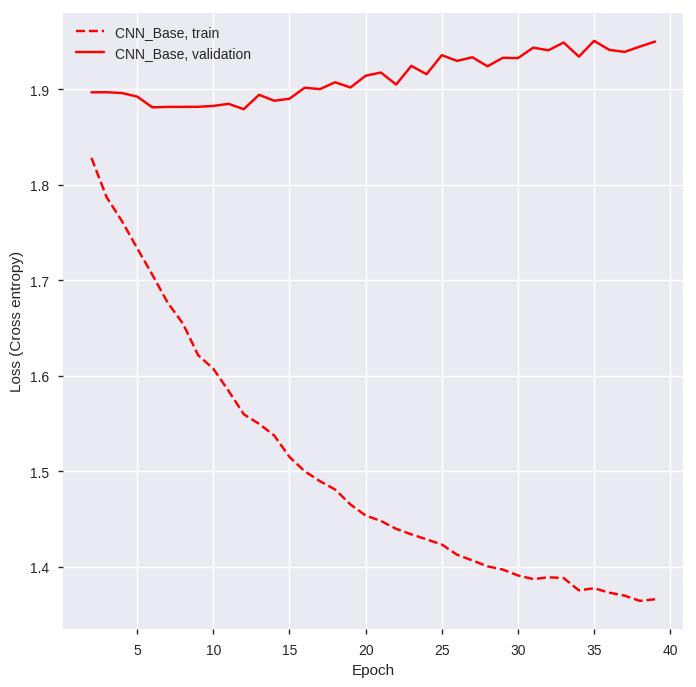

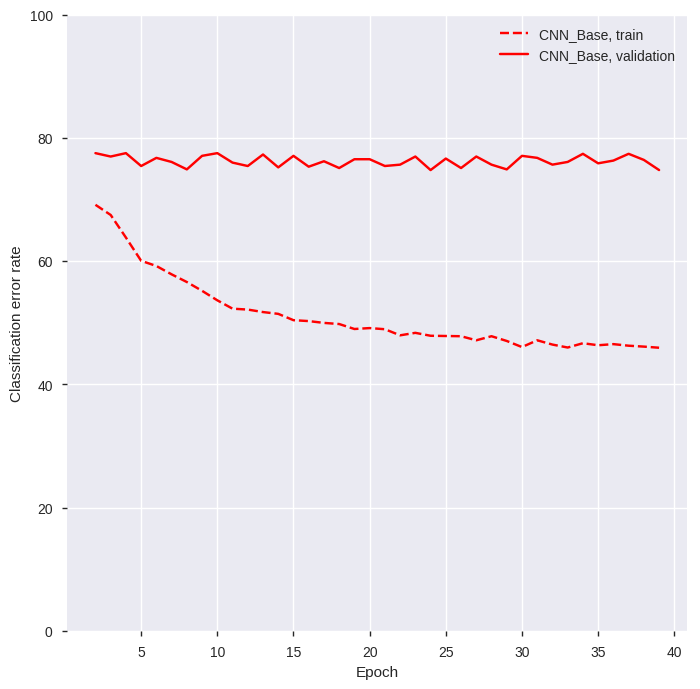

In [761]:

path='plots_current'+ file_separator
n_time_points = shortest_length
f_name = 'cv_freq_all_bad.txt'
file= open(f_name,'r')

lines = json.load(file)
n_models = len(lines)/2
print("There are "+str(n_models)+" models to plot in this file.") #should be 4
print("Print the models all together")
colors = ['r','r','b','b','g','g']
fig1 = plt.figure(figsize=(8,8))
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross entropy)')
for i in range(0,len(lines),2):
    model = lines[i][0]
    tr_loss = lines[i][2][2:]
    val_loss = lines[i+1][2][2:]
    epochs = range(2,len(tr_loss)+2)
    plt.plot(epochs,tr_loss,label=model+', train',color=colors[i],linestyle='--')
    plt.plot(epochs,val_loss,label=model+', validation',color=colors[i+1])
plt.legend()
#plt.savefig(path+"loss_all_freq_"+str(n_time_points)+".png")
fig2 = plt.figure(figsize=(8,8))
plt.xlabel('Epoch')
plt.ylabel('Classification error rate')
for i in range(0,len(lines),2):
    model = lines[i][0]
    tr_err = lines[i][3][2:]
    val_err = lines[i+1][3][2:]
    epochs = range(2,len(tr_err)+2)
    plt.plot(epochs,tr_err,label=model+', train',color=colors[i],linestyle='--')
    plt.plot(epochs,val_err,label=model+', validation',color=colors[i+1])
    plt.ylim((0,100.0))
plt.legend()
#plt.savefig(path+"classErr_all_freq_"+str(n_time_points)+".png")